In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import scipy.stats as ss
import itertools
import sklearn

In [111]:
#If youre feeling risky
import warnings
warnings.filterwarnings("ignore")

In [2]:
# https://www.kaggle.com/c/nfl-playing-surface-analytics/data  has all data info
playlist = pd.read_csv('PlayList.csv')
inj = pd.read_csv('InjuryRecord.csv')
trk = pd.read_csv('PlayerTrackData.csv')

In [3]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267005 entries, 0 to 267004
Data columns (total 14 columns):
PlayerKey         267005 non-null int64
GameID            267005 non-null object
PlayKey           267005 non-null object
RosterPosition    267005 non-null object
PlayerDay         267005 non-null int64
PlayerGame        267005 non-null int64
StadiumType       250095 non-null object
FieldType         267005 non-null object
Temperature       267005 non-null int64
Weather           248314 non-null object
PlayType          266638 non-null object
PlayerGamePlay    267005 non-null int64
Position          267005 non-null object
PositionGroup     267005 non-null object
dtypes: int64(5), object(9)
memory usage: 28.5+ MB


In [4]:
inj.head()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [5]:
trk.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


In [6]:
playlist.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


Those Heckin NaNs

In [7]:
playlist.keys()

Index(['PlayerKey', 'GameID', 'PlayKey', 'RosterPosition', 'PlayerDay',
       'PlayerGame', 'StadiumType', 'FieldType', 'Temperature', 'Weather',
       'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup'],
      dtype='object')

I want to formulate a master data frame from which I can extract features from and kick out all the ones I dont need

Have to get Stadium Type and Weather into workable forms.

In [8]:
# .str vectorizes column (instead of evaluating as a series, goes line by line)
# Weather Conditions (Just the Major weather conditions)
playlist['Cloudy'] = playlist['Weather'].str.contains('Cloudy|cloudy', na = False, regex=True)
playlist['Sunny'] = playlist['Weather'].str.contains('Sunny|Sun|Clear|sunny|clear', na = False, regex = True)
playlist['Snow'] = playlist['Weather'].str.contains('Snow|snow|Snowy|snowy', na = False, regex = True)
playlist['Rain'] = playlist['Weather'].str.contains('Rain|rain|Rainy|rainy|Showers|shower', na = False, regex = True)
playlist['Indoor'] = playlist['Weather'].str.contains('Indoor|indoor|Controlled Climate', na = False, regex = True)
# Grass type (All types included)
playlist['Synthetic'] = playlist['FieldType'].str.contains('Synthetic', regex = True)
playlist['Natural'] = playlist['FieldType'].str.contains('Natural', regex = True)
# Grass type (All types included)
playlist['Indoor'] = playlist['StadiumType'].str.contains('Indoor|Closed|closed|Indoors', na = False, regex = True)
playlist['Outdoor'] = playlist['StadiumType'].str.contains('Outdoor|Oudoor|Ourdoor|Outdoors|Open|Bowl|Outddors|open|Heinz|outdor|Outside', na = False, regex = True)



In [9]:
clean_df = playlist.drop(columns = [ 'Weather', 'FieldType','StadiumType'])

In [10]:
inj_df = inj.dropna().merge(clean_df, left_on=['PlayKey'], right_on=['PlayKey'], how='left')
inj_df

,PlayerKey_x,GameID_x,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey_y,...,Position,PositionGroup,Cloudy,Sunny,Snow,Rain,Indoor,Synthetic,Natural,Outdoor
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,39873,...,OLB,LB,True,False,False,False,True,True,False,False
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,46074,...,OLB,LB,True,False,False,False,False,False,True,True
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,36557,...,SS,DB,False,True,False,False,False,True,False,True
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,46646,...,LB,LB,True,False,False,False,False,False,True,True
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,43532,...,WR,WR,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,42418,42418-19,42418-19-15,Ankle,Synthetic,1,0,0,0,42418,...,C,OL,True,False,False,False,True,True,False,False
73,46394,46394-18,46394-18-3,Knee,Synthetic,1,1,0,0,46394,...,TE,TE,True,False,False,False,False,True,False,True
74,45187,45187-9,45187-9-4,Ankle,Natural,1,0,0,0,45187,...,WR,WR,True,False,False,False,False,False,True,True
75,42448,42448-14,42448-14-3,Knee,Synthetic,1,1,1,0,42448,...,WR,WR,True,False,False,False,False,True,False,False


# Firstly, I am going to graph a bunch of different factors, some similar to ones from other competitors, to practice and see if I can gain any new information or inspiration for increasing the amount of features in my ML models. I'll reorganize everything later

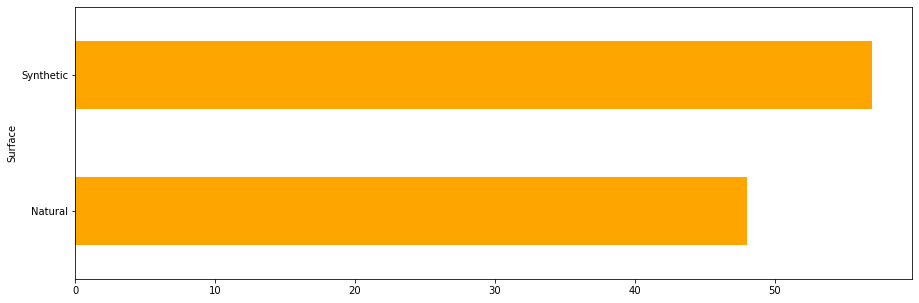

In [11]:
inj.groupby('Surface').count()['PlayerKey'].sort_values().plot(figsize = (15,5), kind = 'barh', color = 'orange')
plt.show()

- Not a huge difference, especially for the number of data points we have.
- Difficult to conclude anything.

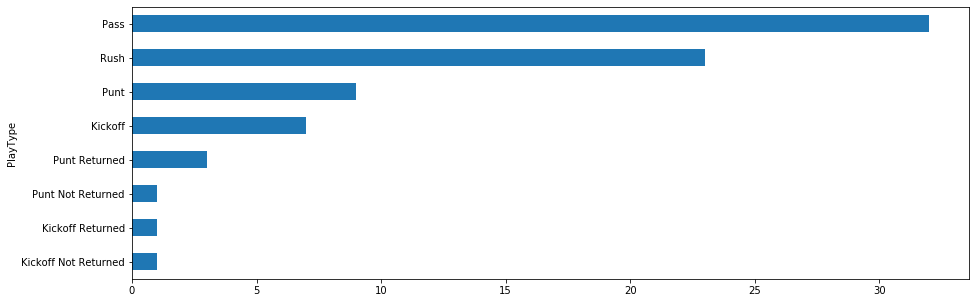

In [12]:
inj_df.groupby('PlayType')['PlayKey'].count().sort_values().plot(figsize = (15,5), kind = 'barh')
plt.show()

As much as I would love to conclude that pass plays are the most dangerous, they do make up a majority of plays.

Lets look at the fractional difference.

In [13]:
inj_play = inj_df.groupby('PlayType')['PlayKey'].count()
inj_play

PlayType
Kickoff                  7
Kickoff Not Returned     1
Kickoff Returned         1
Pass                    32
Punt                     9
Punt Not Returned        1
Punt Returned            3
Rush                    23
Name: PlayKey, dtype: int64

Could have done a for loop for this, but I only had 2 outputs I wanted so I didn't

In [14]:
# Finding fraction of plays where a player was injured on a pass
inj_play = inj_df.groupby('PlayType')['PlayKey'].count()
inj_pass = inj_play.Pass
inj_plays_total = inj_play.sum()
inj_pass_frac = inj_pass/inj_plays_total
print('Fraction of plays that resulted in injury that are also pass plays:', inj_pass_frac)
#Finding fraction of plays that are a passing plays
play = clean_df.groupby('PlayType')['PlayKey'].count()
pass_ = play.Pass
plays_total = play.sum()
pass_frac = pass_/plays_total
print('Fraction of plays that are passing plays:', pass_frac)
#Percent difference 
percent_diff = (abs(inj_pass_frac - pass_frac)/pass_frac) * 100
print('Percent difference is: ', percent_diff, '%')

Fraction of plays that resulted in injury that are also pass plays: 0.4155844155844156
Fraction of plays that are passing plays: 0.5178519190813012
Percent difference is:  19.748406779743906 %


In [15]:
# Finding fraction of plays where a player was injured on a pass
inj_play = inj_df.groupby('PlayType')['PlayKey'].count()
inj_rush = inj_play.Rush
inj_plays_total = inj_play.sum()
inj_rush_frac = inj_rush/inj_plays_total
print('Fraction of plays that resulted in injury that are also rush plays:', inj_rush_frac)
#Finding fraction of plays that are a passing plays
play = clean_df.groupby('PlayType')['PlayKey'].count()
rush_ = play.Rush
plays_total = play.sum()
rush_frac = rush_/plays_total
print('Fraction of plays that are rushing plays:', rush_frac)
#Percent difference 
percent_diff = (abs(inj_rush_frac - rush_frac)/rush_frac) * 100
print('Percent difference is: ', percent_diff, '%')

Fraction of plays that resulted in injury that are also rush plays: 0.2987012987012987
Fraction of plays that are rushing plays: 0.3473098358073493
Percent difference is:  13.995727184937396 %


These numbers are relatively close to one another, so we cannot conclude that there is an increased risk based on the play type. (Only did it on the two most prevalent types since the amount of data for the others is scary small)

In [16]:
Temperature_all = clean_df.Temperature[(clean_df.Temperature > -100) & (clean_df.Temperature < 200)]

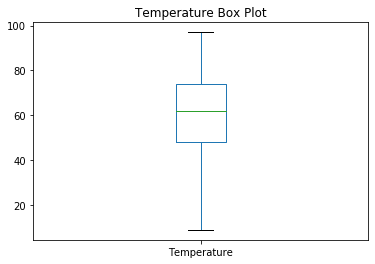

In [17]:
Temperature_all.plot.box(title = 'Temperature Box Plot')

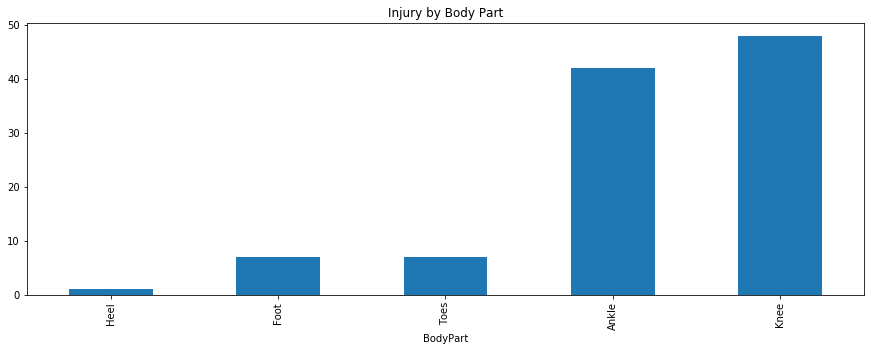

In [18]:
inj.groupby(['BodyPart'])['PlayerKey'].count().sort_values().plot(kind = 'bar', figsize = (15,5), title = 'Injury by Body Part')
plt.show()

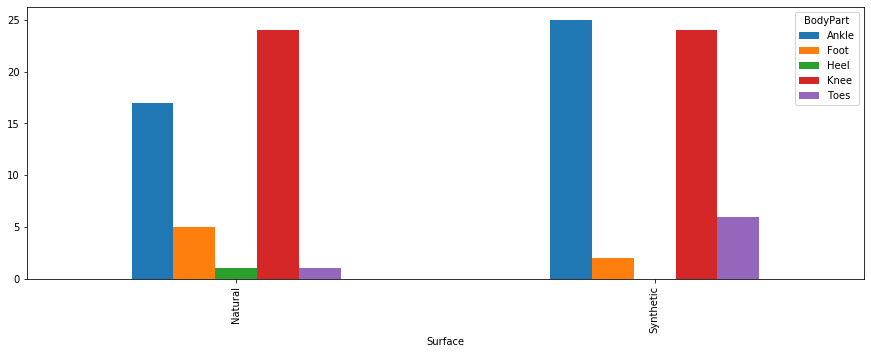

In [19]:
inj.groupby(['BodyPart','Surface'])['PlayerKey'].count().unstack().T.plot(kind = 'bar', figsize = (15,5))
plt.show()

In [20]:
# Want to make sure that all games are accounted for
print(clean_df.GameID.isnull().sum())
df_unique_games = clean_df.drop(columns = ['PlayerKey','PlayKey']).groupby('GameID').first()
# Roster Position just acts as a full row in this instance
dic_of_weathers = {}
def get_weather_counts(weather_type):
    dic_of_weathers["{}_count".format(weather_type)] = df_unique_games.groupby('{}'.format(weather_type))['RosterPosition'].count().loc[True]

get_weather_counts('Cloudy')
get_weather_counts('Sunny')
get_weather_counts('Snow')
get_weather_counts('Rain')
get_weather_counts('Indoor')
print(dic_of_weathers)

0
{'Cloudy_count': 2337, 'Sunny_count': 2044, 'Snow_count': 38, 'Rain_count': 365, 'Indoor_count': 902}


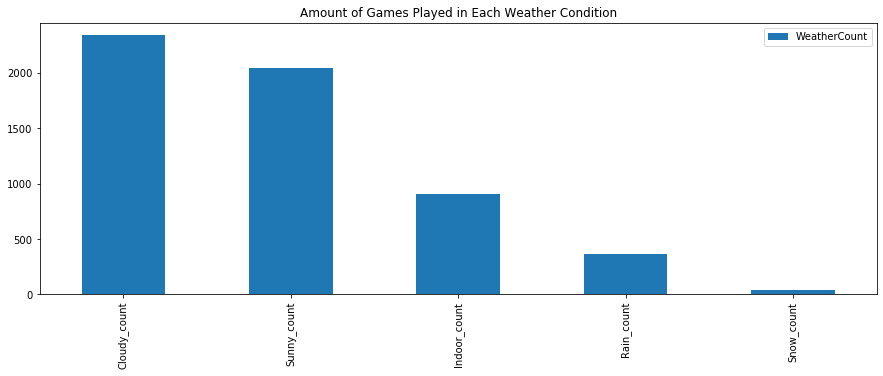

In [21]:
WeatherCount = pd.DataFrame(data = dic_of_weathers.values(),
                            index = dic_of_weathers.keys())\
                            .rename(columns = {0: "WeatherCount"})
WeatherCount.sort_values('WeatherCount', ascending = False).plot(kind = 'bar',
                                                                 title = 'Amount of Games Played in Each Weather Condition',
                                                                 figsize = (15,5))
plt.show()

# Injury Based Data:
We would be wise to make a column based on the injuries that took place and then analyze the coniditions that were in place to see if there is any immediate connection between the factors and injury outcome.

In [22]:
print(inj['PlayKey'].isna().sum())

28


Since there are 28 missing plays from the data set where a player got injured it complicates things on a large scale, but it is not impossible to work with some larger overarching factors that are more game specific than play by play.

In [23]:
merged_inj = inj.merge(right = clean_df, on =['GameID','PlayerKey'], how = 'left')
# Only want the ones that weren't replicated(bc that means that theyre the first unique of their kind), the ~ reverses the
# the boolean series and dropped columns that no longer made sense
merged_inj = merged_inj[~merged_inj.duplicated(subset = ['GameID','PlayerKey'], keep = 'first')]\
    .drop(columns = ['PlayKey_x','PlayKey_y','PlayerGamePlay','PlayType'])

Important to note that we have dropped a single play from the list since he got injured twice in the same game. Since we do not have all of the PlayIDs we cannot properly fill in for everything.

In [24]:
Temperature_inj = merged_inj.Temperature[(merged_inj.Temperature > -100) & (merged_inj.Temperature < 200)]

No handles with labels found to put in legend.


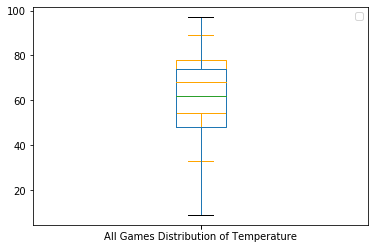

percent diff of temperature in mean of temp  7.352431363593921 %


In [25]:
Temperature_inj = merged_inj.Temperature[(merged_inj.Temperature > -100) & (merged_inj.Temperature < 200)]
Temperature_all = clean_df.Temperature[(clean_df.Temperature > -100) & (clean_df.Temperature < 200)]
fig, ax = plt.subplots()
inj_temp = Temperature_inj.plot.box(Temperature_inj, color = 'orange', label = 'Injury Distribution of Temperature')
all_temp = Temperature_all.plot.box(label = 'All Games Distribution of Temperature')
plt.legend()
plt.show()
print("percent diff of temperature in mean of temp ",(Temperature_inj.mean() - Temperature_all.mean())/Temperature_all.mean() * 100,"%")

In [26]:
merged_inj.DM_M1 = merged_inj.DM_M1 - merged_inj.DM_M7
merged_inj.DM_M7 = merged_inj.DM_M7 - merged_inj.DM_M28
merged_inj.DM_M28 = merged_inj.DM_M28 - merged_inj.DM_M42
merged_inj

,PlayerKey,GameID,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,RosterPosition,PlayerDay,...,Position,PositionGroup,Cloudy,Sunny,Snow,Rain,Indoor,Synthetic,Natural,Outdoor
0,39873,39873-4,Knee,Synthetic,0,0,0,1,Linebacker,29,...,OLB,LB,True,False,False,False,True,True,False,False
32,46074,46074-7,Knee,Natural,0,1,0,0,Linebacker,50,...,OLB,LB,True,False,False,False,False,False,True,True
58,36557,36557-1,Ankle,Synthetic,0,0,0,1,Safety,1,...,SS,DB,False,True,False,False,False,True,False,True
128,46646,46646-3,Ankle,Natural,1,0,0,0,Linebacker,15,...,LB,LB,True,False,False,False,False,False,True,True
158,43532,43532-5,Ankle,Synthetic,0,0,0,1,Wide Receiver,32,...,WR,WR,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,44423,44423-13,Knee,Synthetic,1,0,0,0,Wide Receiver,365,...,WR,WR,False,True,False,False,False,True,False,True
3319,31933,31933-20,Knee,Synthetic,1,0,0,0,Tight End,394,...,TE,TE,True,False,False,False,True,True,False,False
3345,47285,47285-4,Knee,Natural,0,1,0,0,Wide Receiver,22,...,WR,WR,False,False,False,False,False,False,True,False
3361,37068,37068-19,Knee,Natural,0,1,0,0,Linebacker,417,...,OLB,LB,False,True,False,False,False,False,True,True


In [27]:
merged_inj.Injured = merged_inj.DM_M1 + merged_inj.DM_M7 + merged_inj.DM_M28 +merged_inj.DM_M42

C:\Users\12104\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [28]:
clean_df.head()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,Temperature,PlayType,PlayerGamePlay,Position,PositionGroup,Cloudy,Sunny,Snow,Rain,Indoor,Synthetic,Natural,Outdoor
0,26624,26624-1,26624-1-1,Quarterback,1,1,63,Pass,1,QB,QB,False,True,False,False,False,True,False,True
1,26624,26624-1,26624-1-2,Quarterback,1,1,63,Pass,2,QB,QB,False,True,False,False,False,True,False,True
2,26624,26624-1,26624-1-3,Quarterback,1,1,63,Rush,3,QB,QB,False,True,False,False,False,True,False,True
3,26624,26624-1,26624-1-4,Quarterback,1,1,63,Rush,4,QB,QB,False,True,False,False,False,True,False,True
4,26624,26624-1,26624-1-5,Quarterback,1,1,63,Pass,5,QB,QB,False,True,False,False,False,True,False,True


In [29]:
game_df_cleaned =clean_df[['GameID', 'Cloudy', 'Sunny', 'Snow', 'Rain', 'Indoor',
                           'Synthetic', 'Natural', 'Outdoor', 'Temperature', 'Position']]\
.drop_duplicates().reset_index().drop(columns=['index'])

In [30]:
print(game_df_cleaned.keys())
game_df_cleaned.head()

Index(['GameID', 'Cloudy', 'Sunny', 'Snow', 'Rain', 'Indoor', 'Synthetic',
       'Natural', 'Outdoor', 'Temperature', 'Position'],
      dtype='object')


,GameID,Cloudy,Sunny,Snow,Rain,Indoor,Synthetic,Natural,Outdoor,Temperature,Position
0,26624-1,False,True,False,False,False,True,False,True,63,QB
1,26624-2,True,False,False,False,True,True,False,False,85,QB
2,26624-3,False,True,False,False,False,True,False,True,84,QB
3,26624-3,False,True,False,False,False,True,False,True,84,Missing Data
4,26624-4,False,True,False,False,False,True,False,True,61,QB


In [31]:
print(inj.keys())
inj.head()

Index(['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1',
       'DM_M7', 'DM_M28', 'DM_M42'],
      dtype='object')


,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [32]:
game_injury_df = inj.merge(game_df_cleaned, on = 'GameID', how = 'outer').drop_duplicates()
#
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)
#
game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42
#
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey','Surface'])

game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7']\
+ game_injury_df['DM_M28'] + game_injury_df['DM_M42']
#
game_injury_df

,GameID,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42,Cloudy,Sunny,Snow,Rain,Indoor,Synthetic,Natural,Outdoor,Temperature,Position,Injury
0,39873-4,Knee,0,0,0,1,True,False,False,False,True,True,False,False,84,OLB,1
1,46074-7,Knee,0,1,0,0,True,False,False,False,False,False,True,True,76,OLB,1
2,36557-1,Ankle,0,0,0,1,False,True,False,False,False,True,False,True,63,SS,1
3,46646-3,Ankle,1,0,0,0,True,False,False,False,False,False,True,True,80,LB,1
4,43532-5,Ankle,0,0,0,1,True,False,False,False,False,True,False,False,89,WR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,47888-9,NaN,0,0,0,0,True,False,False,False,False,True,False,True,53,DB,0
5738,47888-10,NaN,0,0,0,0,True,False,False,False,False,False,True,True,82,DB,0
5739,47888-11,NaN,0,0,0,0,True,False,False,False,False,False,True,True,42,DB,0
5740,47888-12,NaN,0,0,0,0,False,True,False,False,False,True,False,True,40,DB,0


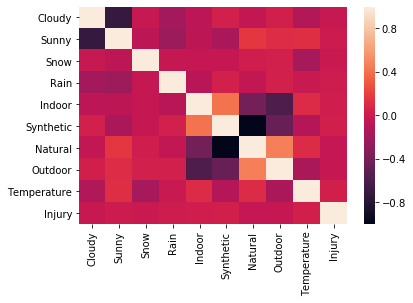

In [33]:
corr_df = game_injury_df.drop(columns = ['DM_M1','DM_M7','DM_M28','DM_M42','GameID','BodyPart'])
corr_df = corr_df[(corr_df.Temperature > -100) & (corr_df.Temperature < 200)]
sns.heatmap(corr_df.corr())

In [34]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


In [35]:
# Source:
# https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
def plot_cramers_v_heatmap(df, cols):
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_v(pd.crosstab(df[col1], df[col2]).as_matrix())
        corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax); ax.set_title("Cramer V Correlation between Variables");

In [36]:
corr_df.keys()

Index(['Cloudy', 'Sunny', 'Snow', 'Rain', 'Indoor', 'Synthetic', 'Natural',
       'Outdoor', 'Temperature', 'Position', 'Injury'],
      dtype='object')

C:\Users\12104\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


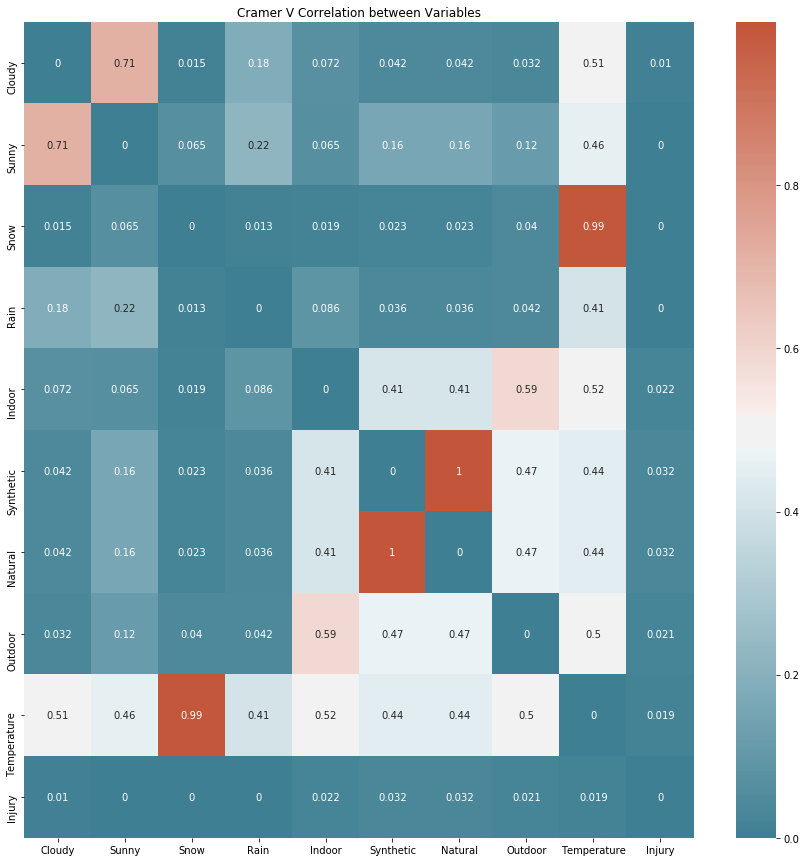

In [37]:
columns = ['Cloudy', 'Sunny', 'Snow', 'Rain', 'Indoor', 'Synthetic', 'Natural',
       'Outdoor', 'Temperature', 'Injury']
plot_cramers_v_heatmap(corr_df, columns)

As far as correlation goes, theres nothing but hot garbage here.

In [38]:
play_injury_df_dummies = pd.get_dummies(corr_df,\
                                        columns = ['Position'], dummy_na = True, drop_first = True)
play_injury_df_dummies = play_injury_df_dummies.drop(columns = ['Position_nan','Position_Missing Data'])

In [39]:
columns = ['Position_CB', 'Position_DB',
       'Position_DE', 'Position_DT', 'Position_FS', 'Position_G',
       'Position_HB', 'Position_ILB', 'Position_K', 'Position_LB',
       'Position_MLB', 'Position_NT', 'Position_OLB', 'Position_P',
       'Position_QB', 'Position_RB', 'Position_S', 'Position_SS', 'Position_T',
       'Position_TE', 'Position_WR','Injury']

C:\Users\12104\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


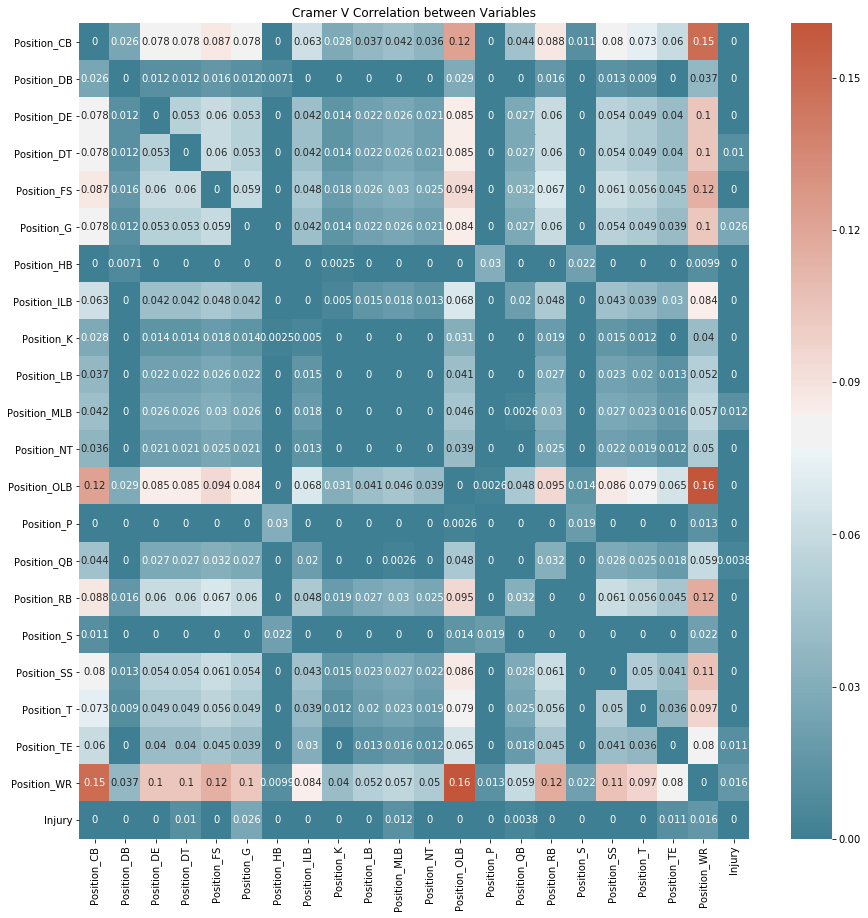

In [40]:
plot_cramers_v_heatmap(play_injury_df_dummies, columns)

And we continue to see no raw correlation between injury and any other feature. Lets Finally work on the last data farme


We should run a simple ML model just to check up how our factors do. Adaboost seems to do well with lots of poorly correlated factors. Lets see how that works.

One of the more complicated aspects of this data set is that there is heavy undersampling of injuries. I turn to Samuel Taylor, a data scientist at Indeed, for help on this. He gave a wonderful lecture that can be found at https://www.samueltaylor.org/articles/how-to-handle-class-imbalance.html on how to deal with class imbalance. I will be implementing some of these techniques in my work and see if any siginificant results occur. I'm also happy I get to use a techinque on a data set so recently after learning how to deal with this specific problem.

In [41]:
corr_df.Injury.value_counts()

0    5103
1      97
Name: Injury, dtype: int64

In [42]:
factors = corr_df.drop(columns = ['Injury','Position'])
output = corr_df.Injury

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(factors, output, test_size = 0.2, random_state = 42)

In [44]:
# Just checking
y_train.value_counts()

0    4089
1      71
Name: Injury, dtype: int64

In [45]:
y_test.value_counts()

0    1014
1      26
Name: Injury, dtype: int64

## Dummy Classifing Model
We should make a dummy classifier. For a case such as this where the class imbalance is so large, predicting no injury for every data point probably creates a really good, but completely useless model. So I think we're going to have to meaure for the true positive predictions.

In [46]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
dumb_model = DummyClassifier(strategy = 'most_frequent').fit(X_train,y_train)
y_pred = dumb_model.predict(X_test)
dumb_accuracy = accuracy_score(y_test, y_pred)
precision = precision_recall_fscore_support(y_test, y_pred)
print(dumb_accuracy)
precision

0.975


C:\Users\12104\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.975, 0.   ]),
 array([1., 0.]),
 array([0.98734177, 0.        ]),
 array([1014,   26], dtype=int64))

In [47]:
# The above array of arrays gives the following information in this order
# Precision: TP/(TP+FP)
# Recall: TP/(TP+FN)
# F-1 Score: 2 *(P*R)/(P+R)
# Total number of elements in our pred/test array

# Real Model Time

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

C:\Users\12104\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.975, 0.   ]),
 array([1., 0.]),
 array([0.98734177, 0.        ]),
 array([1014,   26], dtype=int64))

I freaked out about these results for a minute, but it makes sense. Both models predict the same thing which is that no one ever gets injured. But what I care more about is the true positive rate, so lets go for precision. 

Also, now we will attempt some oversampling techniques for class imbalance to see if we can get better results.

# Undersampling

Real easy. Just sampling from the data set so that the class imbalance is no longer in place, but we have significantly reduced the total number of data points we had before. We are, however, keeping > 60 data points so that our conclusions hold some form of integrity.

In [49]:
factors = corr_df.drop(columns = ['Injury','Position'])
output = corr_df.Injury

In [50]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
factors_res, output_res = rus.fit_resample(factors, output)
print('Resampled dataset shape %s' % Counter(output_res))

Using TensorFlow backend.


Resampled dataset shape Counter({0: 97, 1: 97})


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(factors_res, output_res, test_size = 0.2, random_state = 42)

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.61904762, 0.72222222]),
 array([0.72222222, 0.61904762]),
 array([0.66666667, 0.66666667]),
 array([18, 21], dtype=int64))

In [53]:
# There are more undersampling techniques to pursue in the future if it comes down to it. Reference:
# https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8

# Oversampling:

Three Methods:
    - Random: Replicate data points of minority class
    - SMOTE: Creates data points between minority class data points via clustering
    - ADASYN: Similar process, but slightly different mathematical methodology

Random:

In [54]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
factors_res, output_res = ros.fit_resample(factors, output)
print('Resampled dataset shape %s' % Counter(output_res))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(factors_res, output_res, test_size = 0.2, random_state = 42)

Resampled dataset shape Counter({1: 5103, 0: 5103})


In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.60350877, 0.57203033]),
 array([0.50390625, 0.66699411]),
 array([0.54922831, 0.61587302]),
 array([1024, 1018], dtype=int64))

SMOTE:

In [56]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
factors_res, output_res = smote.fit_resample(factors, output)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(factors_res, output_res, test_size = 0.2, random_state = 42)

In [57]:
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.71675127, 0.69914853]),
 array([0.68945312, 0.7259332 ]),
 array([0.70283723, 0.71228916]),
 array([1024, 1018], dtype=int64))

ADASYN:

In [58]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
factors_res, output_res = adasyn.fit_resample(factors, output)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(factors_res, output_res, test_size = 0.2, random_state = 42)

In [59]:
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.72884615, 0.70746269]),
 array([0.72053232, 0.71601208]),
 array([0.72466539, 0.71171171]),
 array([1052,  993], dtype=int64))

# The Inclusion of Movement

In [60]:
# We'll work with the injury data set afterwards. It's just a big and intimidating data set for computation time. BUT will be
# included in the final project.
len(trk.PlayKey.unique())

266960

In [61]:
trk.head()

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


In [62]:
# Want to do some preliminary testing and aking the data frame smaller will help with computational time


In [63]:
mini = trk.loc[trk.PlayKey == '26624-1-1']

In [64]:
# I am going to model the arrows in my chart like the ones I found from a fellow Kaggle Competitor
# https://www.kaggle.com/robikscube/nfl-1st-and-future-analytics-intro

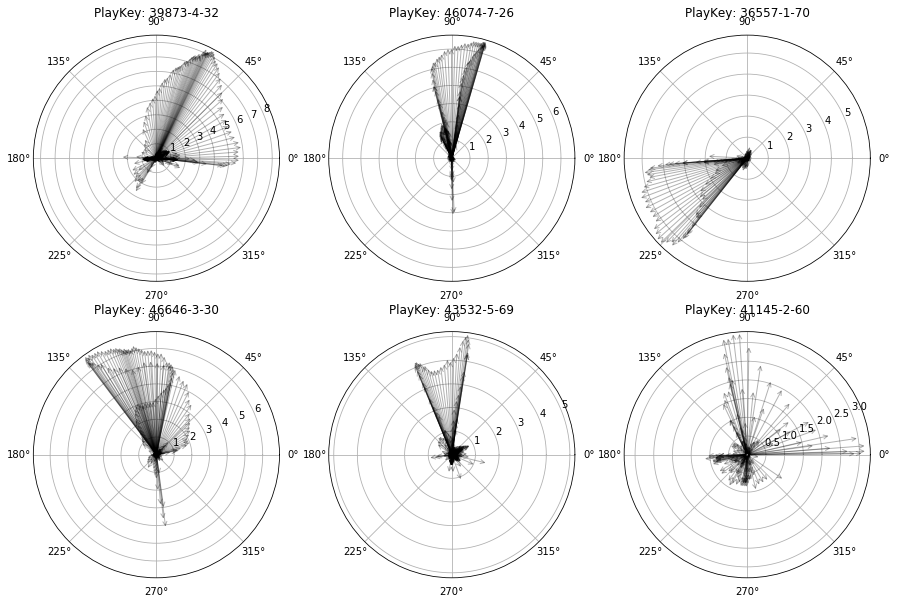

In [65]:
inj_detailed = inj.merge(playlist)
# Only care about the players that were injured and of those, only 77 Play Keys were available 
def compass(angles, radii, arrowprops=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(polar=True))

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0),
                 arrowprops=kw) for
     angle, radius in zip(angles, radii)]

    ax.set_ylim(0, np.max(radii))

    return ax
def compass(angles, radii, arrowprops=None, ax=None):
    """
    * Modified for NFL data plotting
    Compass draws a graph that displays the vectors with
    components `u` and `v` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> u = [+0, +0.5, -0.50, -0.90]
    >>> v = [+1, +0.5, -0.45, +0.85]
    >>> compass(u, v)
    """

    #angles, radii = cart2pol(u, v)
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(polar=True))

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0),
                 arrowprops=kw) for
     angle, radius in zip(angles, radii)]

    ax.set_ylim(0, np.max(radii))

    return ax

def plot_play_compass(playkey, **kwargs):
    d = trk.loc[trk['PlayKey'] == playkey].copy()
    d['dir_theta'] = d['dir'] * np.pi / 180
    # Calculate velocity in meters per second
    d['dis_meters'] = d['dis'] / 1.0936  # Add distance in meters
    # Speed
    d['dis_meters'] / 0.01
    d['v_mps'] = d['dis_meters'] / 0.1

    ax = compass(d['dir_theta'], d['v_mps'],
                  arrowprops={'alpha': 0.3},
                **kwargs)
    return ax
fig, axes = plt.subplots(2, 3,  subplot_kw=dict(polar=True), figsize=(15, 10))
axes = np.array(axes)
axes = axes.reshape(-1)

i = 0
for p in inj_detailed['PlayKey'].values[:6]:
    plot_play_compass(p, ax=axes[i])
    axes[i].set_title(f'PlayKey: {p}')
    i += 1
plt.show()

In [66]:
# Just kind of a cool thing to see, but lets move on to merging data frames in such a way that we can utilize all the info given


## Big Daddy Model Time
Now that I have plenty of graphical information, have identified errors in the data, and extracted plenty of features via dummies, I want to see if I can create a better model than before and see if the player tracking data set even provides any useful insights

First to make the master dataframe. An issue that arises is that only 77 of the plays that resulted in injury had their plays recorded. Going to have to solve this issue somehow.

The solution seems to be to create 2 seperate data sets, otherwise I risk misclassifing a play and, with as small a set of injuries as I have, it could have a large impact on the results.

In [67]:
# Combination of playlist and inj data sets
master_df_1 = corr_df.copy()
master_df_1 = pd.get_dummies(corr_df, columns = ['Position'], dummy_na = True, drop_first = True)
master_df_1 = master_df_1.drop(columns = ['Position_nan','Position_Missing Data'])
master_df_1

,Cloudy,Sunny,Snow,Rain,Indoor,Synthetic,Natural,Outdoor,Temperature,Injury,...,Position_NT,Position_OLB,Position_P,Position_QB,Position_RB,Position_S,Position_SS,Position_T,Position_TE,Position_WR
0,True,False,False,False,True,True,False,False,84,1,...,0,1,0,0,0,0,0,0,0,0
1,True,False,False,False,False,False,True,True,76,1,...,0,1,0,0,0,0,0,0,0,0
2,False,True,False,False,False,True,False,True,63,1,...,0,0,0,0,0,0,1,0,0,0
3,True,False,False,False,False,False,True,True,80,1,...,0,0,0,0,0,0,0,0,0,0
4,True,False,False,False,False,True,False,False,89,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,True,False,False,False,False,True,False,True,53,0,...,0,0,0,0,0,0,0,0,0,0
5738,True,False,False,False,False,False,True,True,82,0,...,0,0,0,0,0,0,0,0,0,0
5739,True,False,False,False,False,False,True,True,42,0,...,0,0,0,0,0,0,0,0,0,0
5740,False,True,False,False,False,True,False,True,40,0,...,0,0,0,0,0,0,0,0,0,0


Now I will use a mix of libraries Stratified K-Fold and imbalance-learn to evently distribute our injuries into the sample and test set and to balance out the class imbalance. DO NOT FORGET TO NORMALIZE.

In [68]:
from sklearn import preprocessing
factors = master_df_1.drop(columns = ['Injury'])
#factors = preprocessing.normalize(factors)
output = master_df_1.Injury

In [69]:
output

0       1
1       1
2       1
3       1
4       1
       ..
5737    0
5738    0
5739    0
5740    0
5741    0
Name: Injury, Length: 5200, dtype: int32

In [70]:
# Evenly distribute injuries into train and test data sets
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold( n_splits=2, shuffle = True)

for train_index, test_index in skf.split(factors,output):
    X_train, X_test = factors.iloc[train_index], factors.iloc[test_index]
    y_train, y_test = output.iloc[train_index], output.iloc[test_index]    
X_train = sklearn.preprocessing.normalize(X_train)
X_test = sklearn.preprocessing.normalize(X_test)


GOT IT! We apply the resampling to the training set and then test our conclusions to the test set. That is how we apply our resampling method appropriately and see how our model sizes up to the real data set!

# Undersampler:

In [71]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
factors_res, output_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(output_res))

Resampled dataset shape Counter({0: 49, 1: 49})


In [72]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98062593, 0.01748808]),
 array([0.51567398, 0.45833333]),
 array([0.67591166, 0.03369066]),
 array([2552,   48], dtype=int64))

# Oversampling:

## Rando:

In [73]:
ros = RandomOverSampler(random_state=42)
factors_res, output_res = ros.fit_resample(X_train, y_train)

In [74]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.9877451 , 0.02398256]),
 array([0.47374608, 0.6875    ]),
 array([0.64036017, 0.04634831]),
 array([2552,   48], dtype=int64))

## SMOTE:

In [75]:
smote = SMOTE(random_state=42)
factors_res, output_res = smote.fit_resample(X_train, y_train)

In [76]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98359865, 0.02656546]),
 array([0.79898119, 0.29166667]),
 array([0.88172973, 0.04869565]),
 array([2552,   48], dtype=int64))

## ADASYN:

In [77]:
adasyn = ADASYN(random_state=42)
factors_res, output_res = adasyn.fit_resample(X_train, y_train)

In [78]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
clf = AdaBoostClassifier(n_estimators = 10, random_state = 0)
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98628049, 0.03322785]),
 array([0.76057994, 0.4375    ]),
 array([0.85884956, 0.06176471]),
 array([2552,   48], dtype=int64))

Adasyn does the best out of the three oversampling methods and better than the undersampling. I will investigate further by sampling 5 different ML methods and see which one performs best, then parameter tune that model.

In [80]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98153242, 0.01818182]),
 array([0.97884013, 0.02083333]),
 array([0.98018442, 0.01941748]),
 array([2552,   48], dtype=int64))

In [81]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98101266, 0.        ]),
 array([0.97178683, 0.        ]),
 array([0.97637795, 0.        ]),
 array([2552,   48], dtype=int64))

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98197837, 0.02912621]),
 array([0.96081505, 0.0625    ]),
 array([0.97128144, 0.0397351 ]),
 array([2552,   48], dtype=int64))

In [88]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(factors_res, output_res)
y_pred = clf.predict(X_test)
precision = precision_recall_fscore_support(y_test, y_pred)
precision

(array([0.98324742, 0.02099237]),
 array([0.59796238, 0.45833333]),
 array([0.74366472, 0.04014599]),
 array([2552,   48], dtype=int64))

Out of the box, logistic regression and adaboost did about the same. They both seem worth tuning, so I'll do just that.

## Hyperparameter Tuning

In [120]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
n_est = [1,2,5,7,10]
l_rate = [1,2,5,7,10]
for x in n_est:
    for y in l_rate:
        clf = AdaBoostClassifier(n_estimators = 10, random_state = 0, learning_rate = y)
        clf.fit(factors_res, output_res)
        y_pred = clf.predict(X_test)
        precision = precision_recall_fscore_support(y_test, y_pred)
        print("n_est = ",x , " l_rate = ", y)
        for a in precision[0:3]:
            print(a)
        print(" ")


n_est =  1  l_rate =  1
[0.98628049 0.03322785]
[0.76057994 0.4375    ]
[0.85884956 0.06176471]
 
n_est =  1  l_rate =  2
[0.98151333 0.01824818]
[0.89459248 0.10416667]
[0.93603936 0.0310559 ]
 
n_est =  1  l_rate =  5
[0.97807309 0.01369863]
[0.57680251 0.3125    ]
[0.72565935 0.02624672]
 
n_est =  1  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  1  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  2  l_rate =  1
[0.98628049 0.03322785]
[0.76057994 0.4375    ]
[0.85884956 0.06176471]
 
n_est =  2  l_rate =  2
[0.98151333 0.01824818]
[0.89459248 0.10416667]
[0.93603936 0.0310559 ]
 
n_est =  2  l_rate =  5
[0.97807309 0.01369863]
[0.57680251 0.3125    ]
[0.72565935 0.02624672]
 
n_est =  2  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  2  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  5  l_rate =  1
[0.98628049 0.03322785]
[0.76057994 0.4375    ]
[0.8588495

In [112]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
n_est = [1,2,5,7,10]
l_rate = [1,2,5,7,10]
for x in n_est:
    for y in l_rate:
        clf = AdaBoostClassifier(n_estimators = 10, random_state = 0, learning_rate = y)
        clf.fit(factors_res, output_res)
        y_pred = clf.predict(X_test)
        precision = precision_recall_fscore_support(y_test, y_pred)
        for z in precision[1:2]:
            if z[1] == 1:
                print("n_est = ",x , " l_rate = ", y)
                for a in precision[0:3]:
                    print(a)
                print(" ")


n_est =  1  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  1  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  2  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  2  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  5  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  5  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  7  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  7  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  10  l_rate =  7
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 
n_est =  10  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]
 


So it looks like we are able to correctly predict all of our injuries at the price of misclassifing plays that did not result in injuries. This seems fine, but now that we have so many versions of our model correctly predicting injuries, I turn to F1-Score to decide which models are better comparitively.

Yikes. They're all predicting the same thing where (I'm assuming) they're all predicting a huge portion of the data is in the injured class and they're all drawing the same line in the sand. 

In [ ]:
# Different penalizing functions were applied to both log reg models

In [119]:
from sklearn.linear_model import LogisticRegression
mx_iter = [10,50,100,150,200]
c = [0.2,0.5,1,2,5,10]
for x in mx_iter:
    for y in c:
        clf = LogisticRegression(penalty = 'l2', C = y, max_iter = x)
        clf.fit(factors_res, output_res)
        y_pred = clf.predict(X_test)
        precision = precision_recall_fscore_support(y_test, y_pred)
        print("max_interations = ",x , " C = ", y)
        for a in precision[0:3]:
            print(a)
        print(" ")

max_interations =  10  C =  0.2
[0.9862259  0.02183984]
[0.42084639 0.6875    ]
[0.58994782 0.04233483]
 
max_interations =  10  C =  0.5
[0.98312236 0.02037351]
[0.54780564 0.5       ]
[0.70357323 0.03915171]
 
max_interations =  10  C =  1
[0.98312784 0.02077432]
[0.59365204 0.45833333]
[0.7402883  0.03974706]
 
max_interations =  10  C =  2
[0.98316708 0.02108434]
[0.61794671 0.4375    ]
[0.75890279 0.04022989]
 
max_interations =  10  C =  5
[0.98334362 0.02145046]
[0.62460815 0.4375    ]
[0.76395878 0.04089581]
 
max_interations =  10  C =  10
[0.98356665 0.02194357]
[0.63322884 0.4375    ]
[0.770441   0.04179104]
 
max_interations =  50  C =  0.2
[0.98623853 0.0218543 ]
[0.42123824 0.6875    ]
[0.59033498 0.042362  ]
 
max_interations =  50  C =  0.5
[0.9831815  0.02046036]
[0.54976489 0.5       ]
[0.70520231 0.03931204]
 
max_interations =  50  C =  1
[0.98324742 0.02099237]
[0.59796238 0.45833333]
[0.74366472 0.04014599]
 
max_interations =  50  C =  2
[0.98360656 0.02169625]
[

In [118]:
from sklearn.linear_model import LogisticRegression
mx_iter = [10,50,100,150,200]
c = [0.2,0.5,1,2,5,10]
for x in mx_iter:
    for y in c:
        clf = LogisticRegression(penalty = 'none', C = y, max_iter = x)
        clf.fit(factors_res, output_res)
        y_pred = clf.predict(X_test)
        precision = precision_recall_fscore_support(y_test, y_pred)
        print("max_interations = ",x , " C = ", y)
        for a in precision[0:3]:
            print(a)
        print(" ")

max_interations =  10  C =  0.2
[0.98294829 0.02173913]
[0.70023511 0.35416667]
[0.81784897 0.04096386]
 
max_interations =  10  C =  0.5
[0.98294829 0.02173913]
[0.70023511 0.35416667]
[0.81784897 0.04096386]
 
max_interations =  10  C =  1
[0.98294829 0.02173913]
[0.70023511 0.35416667]
[0.81784897 0.04096386]
 
max_interations =  10  C =  2
[0.98294829 0.02173913]
[0.70023511 0.35416667]
[0.81784897 0.04096386]
 
max_interations =  10  C =  5
[0.98294829 0.02173913]
[0.70023511 0.35416667]
[0.81784897 0.04096386]
 
max_interations =  10  C =  10
[0.98294829 0.02173913]
[0.70023511 0.35416667]
[0.81784897 0.04096386]
 
max_interations =  50  C =  0.2
[0.98571429 0.02525253]
[0.6218652  0.52083333]
[0.76261413 0.04816956]
 
max_interations =  50  C =  0.5
[0.98571429 0.02525253]
[0.6218652  0.52083333]
[0.76261413 0.04816956]
 
max_interations =  50  C =  1
[0.98571429 0.02525253]
[0.6218652  0.52083333]
[0.76261413 0.04816956]
 
max_interations =  50  C =  2
[0.98571429 0.02525253]
[

# Conclusion
At the end of the day, it become a question of what is more important. Is it more important to predict injury when it happens? Is it more important to not misclassify? Or is there a harmonic mean we would be happy with?

The following results for the max value of each given our algorithms:

Max Precision: AdaBoost
n_est =  1  l_rate =  1
[0.98628049 0.03322785]
[0.76057994 0.4375    ]
[0.85884956 0.06176471]

Max Recall: AdaBoost
n_est =  1  l_rate =  10
[0.         0.01846154]
[0. 1.]
[0.         0.03625378]

Best F1-Score: AdaBoost
n_est =  1  l_rate =  1
[0.98628049 0.03322785]
[0.76057994 0.4375    ]
[0.85884956 0.06176471]


# To Do List:
    -Create more features from data given
    -Take away correlated features to improve our models